## Подготовка данных

### Загрузка данных

Гайд по скачиванию:
https://www.metagenomics.wiki/tools/fastq/ncbi-ftp-genome-download

In [1]:
import gzip

!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz'
!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz'

!gunzip GCF_000355675.1_ASM35567v1_genomic.fna.gz
!gunzip GCF_000355675.1_ASM35567v1_genomic.gbff.gz

--2024-11-14 21:02:13--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.31, 130.14.250.10, 130.14.250.11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1168222 (1.1M) [application/x-gzip]
Saving to: ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’

GCF_000355675.1_ASM 100%[===================>]   1.11M  2.55MB/s    in 0.4s    

2024-11-14 21:02:13 (2.55 MB/s) - ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’ saved [1168222/1168222]

--2024-11-14 21:02:14--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.31, 130.14.250.10, 130.14.250.11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.1

### Reading sequences

In [2]:
!pip install bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 40.4 MB/s eta 0:00:00


In [3]:
from Bio import SeqIO
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

seq = None
gb = None

# считываем скачанные файлы
for record in SeqIO.parse("/content/GCF_000355675.1_ASM35567v1_genomic.fna", "fasta"):
    seq = record.seq

for record in SeqIO.parse('/content/GCF_000355675.1_ASM35567v1_genomic.gbff', 'genbank'):
    gb = record

In [4]:
start, end = gb.features[0].location.start, None

ncod = []
cod = []

# записываем кодирующие и некодирующие последовательности
for feature in gb.features:
    fseq = feature.extract(seq)

    end = feature.location.start

    if feature.type == 'CDS' and fseq[:3] == 'ATG' and len(fseq) % 3 == 0:
        cod.append(fseq.__str__())

        if len(seq[start:end]) != 0:
            ncod.append(seq[start:end].__str__())

        start = feature.location.end

### Initial probabilities

In [5]:
def seq_probs(seq):
    return np.array([
        seq.count('T'), seq.count('C'),
        seq.count('A'), seq.count('G')
    ]) / len(seq)

def cod_probs(seq):
    res = []
    for i in range(3):
        res.append(seq_probs(seq[i::3]))
    return np.array(res)

def make_table1(cod_seqs, ncod_seqs):
    table1 = pd.DataFrame(np.vstack((cod_probs(''.join(cod_seqs)), seq_probs(''.join(ncod_seqs)))).T,
                        index=['T', 'C', 'A', 'G'],
                        columns=[f'pos{i}' for i in range(1, 4)] + ['nc'])
    return table1

In [6]:
t1 = make_table1(cod, ncod)
t1

,pos1,pos2,pos3,nc
T,0.181143,0.296068,0.315043,0.273024
C,0.206706,0.227065,0.233173,0.228923
A,0.256916,0.302111,0.238480,0.276478
G,0.355236,0.174755,0.213304,0.221574


### Transition probabilities

In [7]:
def cod_dprobs(seqs):
    dcounts = dict(
        zip([1, 2, 3],
            [dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                    [0] * 16)) for i in range(3)])
        )
    for seq in seqs:
        for i in range(1, len(seq)):
            dcounts[i % 3 + 1][seq[i-1:i+1]] += 1
    return get_probs(dcounts)

def ncod_dprobs(seqs):
    dcounts =dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                    [0] * 16))
    for seq in seqs:
      for i in range(1, len(seq)):
        dcounts[seq[i-1:i+1]] += 1

    return get_probs({0: dcounts})[0]

def get_probs(dcounts):
  for pos in dcounts:
    nuc_groups = dict(zip('TCAG', [0] * 4))
    for dup in dcounts[pos]:
      nuc_groups[dup[0]] += dcounts[pos][dup]
    for dup in dcounts[pos]:
      dcounts[pos][dup] /= nuc_groups[dup[0]]
  return dcounts

def make_table2(cod_seqs, ncod_seqs):
  table2 = pd.DataFrame(cod_dprobs(cod_seqs))
  table2[4] = pd.Series(ncod_dprobs(ncod_seqs))
  table2.rename(columns=dict(zip(np.arange(1, 5),
                                 [f'pos{i}' for i in range(1, 4)] + ['nc'])),
                inplace=True)
  table2.index = [prob_notation(idx) for idx in table2.index.values]
  return table2

def prob_notation(st):
  return st[1] + '|' + st[0]

In [8]:
t2 = make_table2(cod, ncod)
t2

,pos1,pos2,pos3,nc
T|T,0.185482,0.497862,0.316308,0.318271
C|T,0.189688,0.199483,0.179891,0.208911
A|T,0.249131,0.172440,0.221458,0.243934
G|T,0.375698,0.130215,0.282343,0.228884
T|C,0.185235,0.248571,0.269872,0.252402
C|C,0.156213,0.197930,0.244217,0.214059
A|C,0.276197,0.315174,0.244461,0.286765
G|C,0.382355,0.238325,0.241449,0.246775
T|A,0.179889,0.334011,0.307774,0.270128
C|A,0.194131,0.213909,0.193560,0.205302


TATTACTTC
P(seq NC)=P(T|NC)*Pnc(A|T)*Pnc(T|A)*P(T|T)*P(A|T)...

In [9]:
P_seq_nc = t1['nc']['T'] * t2['nc']['A|T']*t2['nc']['T|A']*t2['nc']['T|T']*t2['nc']['A|T']*t2['nc']['C|A']*t2['nc']['T|C']*t2['nc']['T|T']*t2['nc']['C|T']
P_seq_nc

4.812341505624151e-06

In [10]:
t2['nc']['A|T']

0.24393437391475742

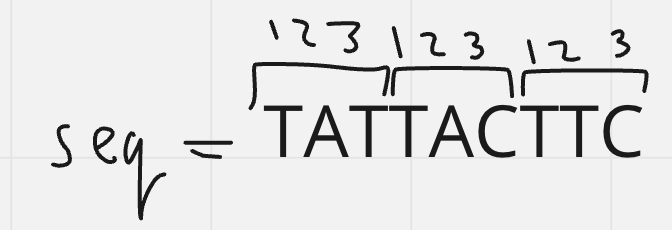

In [11]:
P_seq_cod = t1['pos1']['T']   * t2['pos2']['A|T'] * t2['pos3']['T|A'] * \
            t2['pos1']['T|T'] * t2['pos2']['A|T'] * t2['pos3']['C|A'] * \
            t2['pos1']['T|C'] * t2['pos2']['T|T'] * t2['pos3']['C|T']
P_seq_cod

9.873955022651802e-07

In [12]:
P_nc = 0.5
P_cod = 0.5
P_nc_seq = P_nc * P_seq_nc / (P_nc * P_seq_nc + P_cod * P_seq_cod)
P_nc_seq

0.8297516765118772

In [13]:
P_cod_seq = P_cod * P_seq_cod / (P_nc * P_seq_nc + P_cod * P_seq_cod)
P_cod_seq

0.17024832348812277

In [14]:
1-P_nc_seq

0.1702483234881228

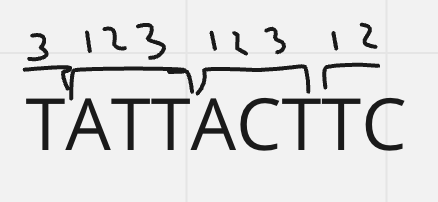

In [15]:
P_seq_cod2 = t1['pos3']['T'] * \
            t2['pos1']['A|T'] * t2['pos2']['T|A'] * t2['pos3']['T|T'] * \
            t2['pos1']['A|T'] * t2['pos2']['C|A'] * t2['pos3']['T|C'] * \
            t2['pos1']['T|T'] * t2['pos2']['C|T']
P_seq_cod2

4.4125895605963545e-06

## Основная часть

Функция для нахождения вероятности данного кодона

In [16]:
def cod_proba(seq, t1, t2, frame=1):
    if len(seq) == 0:
        print('No sequence')
        return None

    if frame not in [1, 2, 3]:
        print('No such frame')
        return None

    prev_nuc = seq[0]
    delta = (4 - frame) % 3
    pos = delta % 3 + 1

    log_prob = np.log(t1[f'pos{pos}'][prev_nuc])

    for i, nuc in enumerate(seq[1:], pos):
        pos = (i + delta) % 3 + 1
        pair = '{}|{}'.format(nuc, prev_nuc)
        log_prob += np.log(t2[f'pos{pos}'][pair])
        prev_nuc = nuc

    return np.exp(log_prob)

def ncod_proba(seq, t1, t2):
    if len(seq) == 0:
        print('No sequence')
        return None

    prev_nuc = seq[0]
    start_pos = delta = 1

    log_prob = np.log(t1['nc'][prev_nuc])

    for i, nuc in enumerate(seq[1:], start_pos):
        pair = '{}|{}'.format(nuc, prev_nuc)
        log_prob += np.log(t2['nc'][pair])
        prev_nuc = nuc

    return np.exp(log_prob)

In [17]:
def get_cod_probs(seq, t1, t2):
    frames = [1, 2, 3, 'nc']
    result = {frame: cod_proba(seq, t1, t2, frame) for frame in frames[:-1]}
    result[frames[-1]] = ncod_proba(seq, t1, t2)
    return result

In [18]:
def plot_graph(data, start, end, step, window, positive=True):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

    x = np.array([])
    y1, y2, y3 = np.array([]), np.array([]), np.array([])

    axis = (ax1, ax2, ax3)
    ys = [y1, y2, y3]

    for i in range(start, end, step):
        seq = data[i:i+window]
        probs = get_cod_probs(seq, t1, t2)

        x = np.append(x, [i], axis=0)
        for j in range(len(ys)):
            ys[j] = np.append(ys[j],
                [probs[j + 1] / (
                    probs[1] + probs[2] + probs[3]
                    + P_nc / P_cod * probs['nc']
                )], axis=0)


    for i, ax in enumerate(axis):
        ax.set_title(f'{"Negative " * (not positive)}Codon position {i + 1}')
        ax.plot(x, ys[i])

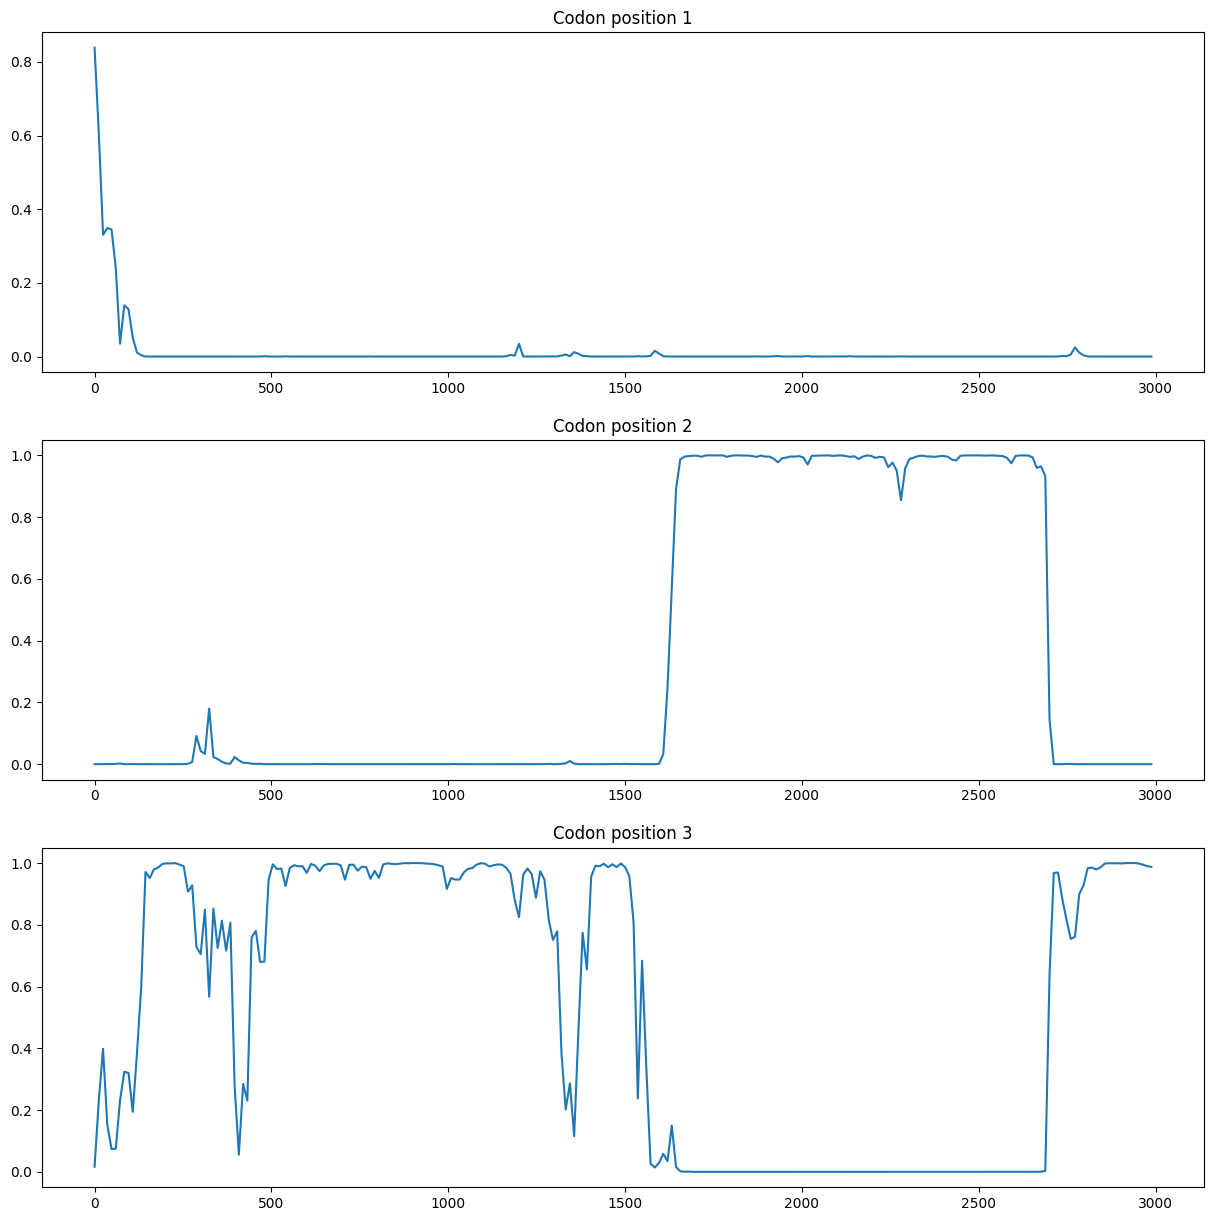

In [19]:
start = 0
end = 3000
step = 12
window = 96
subseq = seq[start:(start + end + window)]
plot_graph(str(subseq), start, end, step, window)

## Бонусная часть 1

In [20]:
!pip install tqdm

In [21]:
from Bio.Data import CodonTable

In [22]:
def cod_proba96(data, t1, t2, start=0):
    result = {'start': [], 1: [], 2: [], 3: []}
    for i in range(start, end, step):
        seq = data[i:i+window]
        probs = get_cod_probs(seq, t1, t2)

        result['start'].append(i)
        for j in range(1, 4):
            result[j].append(probs[j] / (
                    probs[1] + probs[2] + probs[3]
                    + P_nc / P_cod * probs['nc']
                ))

    return result

In [23]:
subseq_start = 0
results = pd.DataFrame(cod_proba96(subseq, t1, t2, start=subseq_start))

In [24]:
def find_orfs_with_trans(seq, trans_table=11, min_protein_length=50):
    answer = []
    seq_len = len(seq)
    for strand, nuc in [(+1, seq), (-1, seq.reverse_complement())]:
        frame = 0
        trans = nuc[frame:].translate(trans_table)
        trans_len = len(trans)
        aa_start = 0
        aa_end = 0
        while aa_start < trans_len:
            aa_end = trans.find("*", aa_start)
            if aa_end == -1:
                aa_end = trans_len
            if aa_end - aa_start >= min_protein_length:
                if strand == 1:
                    start = frame + aa_start * 3
                    end = min(seq_len, frame + aa_end * 3 + 3)
                else:
                    start = seq_len - frame - aa_end * 3 - 3
                    end = seq_len - frame - aa_start * 3
                answer.append((start, end, strand, trans[aa_start:aa_end]))
            aa_start = aa_end + 1
    answer.sort()
    return answer

def find_codons(seq):
    table = CodonTable.unambiguous_dna_by_id[11]
    ans = {'start': [], 'stop': []}
    for k, v in zip(('start', 'stop'), (table.start_codons, table.stop_codons)):
        for codon in v:
            for idx in range(0, len(seq), 3):
                if seq[idx:idx+3] == codon:
                    ans[k].append(idx)
    return {k: list(sorted(v)) for k, v, in ans.items()}

In [25]:
def plot_graph_orfs(data, step):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
    for i, ax in enumerate((ax1, ax2, ax3)):
        j = {0:0, 1:2, 2: 1}[i]

        # plot ORFs with probabilities
        for (start, stop, _, __) in filter(lambda x: x[2] == 1, find_orfs_with_trans(subseq[j:], min_protein_length=40)):
            ax.plot([start, stop], [0.5, 0.5], color='black', linewidth=1)
            ax.scatter([start], [0.5], marker=2, color='black', s=20)
            ax.scatter([stop], [0.5], marker=3, color='black', s=20)

            ax.plot([start], [-0.05], marker=">" , color='royalblue')
            ax.plot([stop], [-0.05], marker="<", color='lightcoral')
            ax.plot([start, stop], [-0.05, -0.05], color='black', linewidth=5)
            ax.text((start + stop) / 2 - 50, -0.15, f"{results[i + 1][(start // step):((stop // step) + 1)].mean():.2f}", color='black')

        # plot start and stop codons
        codons = find_codons(subseq[j:])
        ax.scatter(codons['start'], [0.1 for k in codons['start']], marker=">", color='royalblue', label='start codons')
        ax.scatter(codons['stop'], [0.1 for k in codons['stop']], marker="<", color='lightcoral', label='stop codons')

        # plot probability values
        ax.plot(results['start'] + 48, results[i + 1])
        ax.set_title(f'Codon position {i + 1}')
        ax.set_ylim((-0.2, 1.2))
        ax.legend()

/usr/local/lib/python3.10/dist-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


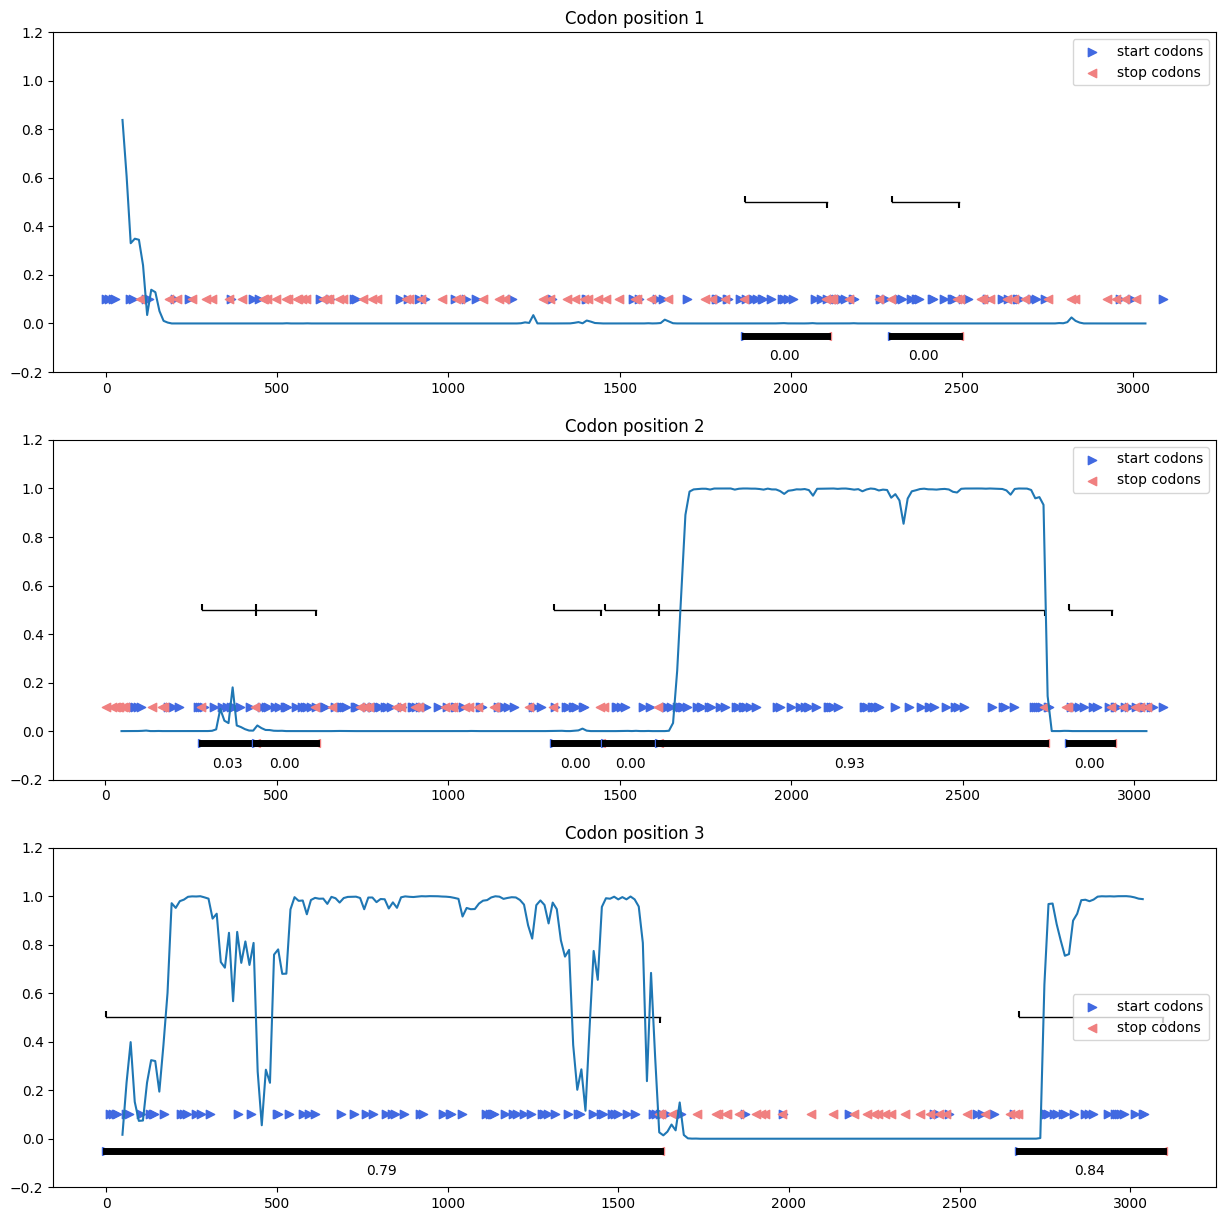

In [26]:
plot_graph_orfs(str(subseq), step)